### Import Libraries

In [1]:
import h5py
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns

### Load Data

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"
cube = h5py.File(CUBE_PATH, "r")

spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
images = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:]
metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")

In [3]:
print(list(cube["dense_cube/0/ml_image"].keys()))

['cutout_3d_cube_zoom_0', 'errors', 'image_cutout_refs', 'image_metadata_refs']


### All sfrs columns

In [4]:
print(", ".join(sfrs.columns))

SIMPLE, BITPIX, NAXIS, EXTEND, TELESCOP, FLAVOR, BOSSVER, MJD, MJDLIST, NAME, PLATEID, TILEID, CARTID, MAPID, RA_x, DEC_x, EQUINOX, RADECSYS, RADEG, DECDEG, BOREOFFX, BOREOFFY, GUIDOFFY, PRESSURE, WINDD, WINDS, GUSTD, GUSTS, AIRTEMP, DEWPOINT, DPERRPT, HUMIDITY, DUSTA, DUSTB, WINDD25M, WINDS25M, SLITID2, BESTEXP, NEXP_B1, NEXP_R1, EXPT_B1, EXPT_R1, EXPTIME, SPCOADD, SHOPETIM, SHCLOTIM, LN2TEMP, CCDTEMP, IONPUMP, VERSIDL, VERSUTIL, VERSREAD, VERS2D, VERSCOMB, VERSLOG, VERSFLAT, RDNOISE0, BADPIXEL, RUN2D, REDDEN01, REDDEN02, REDDEN03, REDDEN04, REDDEN05, PLUGFILE, HELIO_RV, VACUUM, SFLATTEN, PSFSKY, SKYCHI2, SCHI2MIN, SCHI2MAX, PREJECT, SPEC1_G, SN2EXT1G, SPEC1_R, SN2EXT1R, SPEC1_I, SN2EXT1I, SPEC2_G, SN2EXT2G, SPEC2_R, SN2EXT2R, SPEC2_I, SN2EXT2I, NSTD, GOFFSTD, GRMSSTD, ROFFSTD, RRMSSTD, IOFFSTD, IRMSSTD, GROFFSTD, GRRMSSTD, RIOFFSTD, RIRMSSTD, LOWREJ, HIGHREJ, SCATPOLY, PROFTYPE, NFITPOLY, XCHI2, NWORDER, WFITTYPE, COEFF0, COEFF1, FBADPIX, FBADPIX1, FBADPIX2, WAT0_001, WAT1_001, DC-FL

### Columns that can be considered as Y:

TARGETTYPE – type of target object (e.g. star, quasar, galaxy).

SPECTROTYPE – spectral type of object (e.g. STAR, QSO, GALAXY).

SUBCLASS – subclass of spectral type (can give more detailed division).

Z – redshift, used in astrophysics to analyze the distance of objects.

Z_ERR – redshift measurement error.

Z_WARNING – redshift quality warning flag.

V_DISP – object velocity dispersion.

V_DISP_ERR – velocity dispersion error.

SN_MEDIAN – median signal-to-noise ratio, can indicate data quality.

In [5]:
categorical_columns = ["TARGETTYPE", "SPECTROTYPE", "SUBCLASS"]
numerical_columns = ["Z", "Z_ERR", "Z_WARNING", "V_DISP", "V_DISP_ERR", "SN_MEDIAN"]

### Categorical variables:

In [6]:
for col in categorical_columns:
    print(f"\nCategories for the column {col}:")
    print(sfrs[col].value_counts())


Categories for the column TARGETTYPE:


/tmp/ipykernel_246367/2009885943.py:3: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  print(sfrs[col].value_counts())


TARGETTYPE
b'nan'                    3925637
b'GALAXY             '     873736
b'QSO                '      28778
b'QA                 '      16319
b'SERENDIPITY_FIRST  '       2870
b'ROSAT_D            '       1648
b'SERENDIPITY_BLUE   '        481
b'STAR_RED_DWARF     '        335
b'ROSAT_C            '        263
b'STAR_SUB_DWARF     '        249
b'STAR_BHB           '        222
b'SERENDIPITY_DISTANT'        179
b'STAR_WHITE_DWARF   '        161
b'STAR_CARBON        '         91
b'STAR_CATY_VAR      '         49
b'SERENDIPITY_MANUAL '         48
b'ROSAT_A            '         31
b'STAR_BROWN_DWARF   '         24
b'REDDEN_STD         '         22
b'SKY                '         15
b'SERENDIPITY_RED    '         12
b'SPECTROPHOTO_STD   '         10
b'HOT_STD            '          9
b'STAR_PN            '          8
b'ROSAT_B            '          3
Name: count, dtype: int64

Categories for the column SPECTROTYPE:


/tmp/ipykernel_246367/2009885943.py:3: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  print(sfrs[col].value_counts())


SPECTROTYPE
b'nan'       3925637
b'GALAXY'     923917
b'QSO   '       1646
Name: count, dtype: int64

Categories for the column SUBCLASS:
SUBCLASS
b'nan'                      3925637
b'                     '     578120
b'STARFORMING          '     247149
b'STARBURST            '      65734
b'AGN                  '      16815
b'BROADLINE            '      13392
b'AGN BROADLINE        '       2870
b'STARFORMING BROADLINE'       1135
b'STARBURST BROADLINE  '        348
Name: count, dtype: int64


/tmp/ipykernel_246367/2009885943.py:3: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  print(sfrs[col].value_counts())


### Numeric variables:

In [7]:
for col in numerical_columns:
    print(f"\nSpread of values for column {col}:")
    print(f"Minimum: {sfrs[col].min()}, Maximum: {sfrs[col].max()}")
    print(f"Sample values: {sfrs[col].sample(5).values}")


Spread of values for column Z:
Minimum: -0.011547930538654327, Maximum: 0.6998667120933533
Sample values: [       nan        nan        nan 0.08544418        nan]

Spread of values for column Z_ERR:
Minimum: -6.0, Maximum: 635.6256103515625
Sample values: [         nan          nan 3.983907e-05          nan          nan]

Spread of values for column Z_WARNING:
Minimum: 0.0, Maximum: 146.0
Sample values: [ 0. nan nan  0. nan]

Spread of values for column V_DISP:
Minimum: 0.0, Maximum: 850.0
Sample values: [82.737305       nan 49.87432        nan       nan]

Spread of values for column V_DISP_ERR:
Minimum: -50.0, Maximum: 2262.74169921875
Sample values: [34.680325       nan 17.225975       nan       nan]

Spread of values for column SN_MEDIAN:
Minimum: 0.0007677021785639226, Maximum: 98.18717956542969
Sample values: [nan nan nan nan nan]


In [8]:
print(f"Minimum: {sfrs['FLAG'].min()}, Maximum: {sfrs[col].max()}")
print(f"Sample values: {sfrs['FLAG'].sample(125).values}")

Minimum: 0.0, Maximum: 98.18717956542969
Sample values: [nan nan nan nan nan nan nan  0. nan nan nan nan nan nan nan nan nan nan
  0. nan nan nan nan nan nan nan nan nan nan  0. nan  0.  0. nan nan nan
 nan  0. nan nan nan nan  0. nan  0. nan nan nan nan nan nan  0.  0.  0.
 nan nan nan  0. nan nan nan nan nan nan  0. nan  0.  0. nan  0. nan  0.
 nan nan nan nan nan nan  0.  0. nan nan nan nan nan nan  2. nan  0. nan
 nan nan nan nan  1. nan nan nan nan nan nan nan nan  0. nan nan  0. nan
 nan nan nan nan nan nan nan nan nan  0. nan nan nan nan  0. nan nan]


### Process Data

In [9]:
sfrs_notna = sfrs.loc[sfrs["FLAG"] == 0.0].copy()
metadata_indices = metadata[:, 0]["ds_slice_idx"]
common_indices = np.intersect1d(metadata_indices, sfrs_notna.index.values)
idx_spectra = np.isin(metadata_indices, common_indices)
X_spectra = spectra[idx_spectra]

In [10]:
nan_rows = np.isnan(X_spectra).any(axis=1)
nan_removed = np.sum(nan_rows)
X_spectra = X_spectra[~nan_rows]

The only column that allows classification into stars/quasars/galaxies is TARGETTYPE, which can be simplified:

In [11]:
def simplify_targettype(value):
    value = value.decode("utf-8").strip()
    if "GALAXY" in value:
        return "GALAXY"
    elif "QSO" in value or "QA" in value:
        return "QUASAR"
    elif "STAR" in value:
        return "STAR"
    else:
        return "OTHER" 

In [12]:
sfrs_z_filtered = sfrs.loc[sfrs["Z"] >= 0.0].copy()
z_retained = len(sfrs_z_filtered)
z_removed = len(sfrs) - z_retained

In [13]:
sfrs_z_filtered.loc[:, "Simplified_TARGETTYPE"] = sfrs_z_filtered["TARGETTYPE"].apply(simplify_targettype)
Y = sfrs_z_filtered.loc[metadata_indices[idx_spectra], "Simplified_TARGETTYPE"].values
Y = Y[~nan_rows]

In [14]:
n_samples = len(common_indices)
X_images = images[:n_samples].reshape(n_samples, -1)
nan_rows_images = np.isnan(X_images).any(axis=1)

X_images_final = X_images[~nan_rows_images]
Y_images_final = Y[:X_images_final.shape[0]]

print(f"Final X_images shape: {X_images_final.shape}")
print(f"Final Y_images shape: {Y_images_final.shape}")

Final X_images shape: (16830, 20480)
Final Y_images shape: (11179,)


### Plot Class Distribution

/tmp/ipykernel_246367/3962009766.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


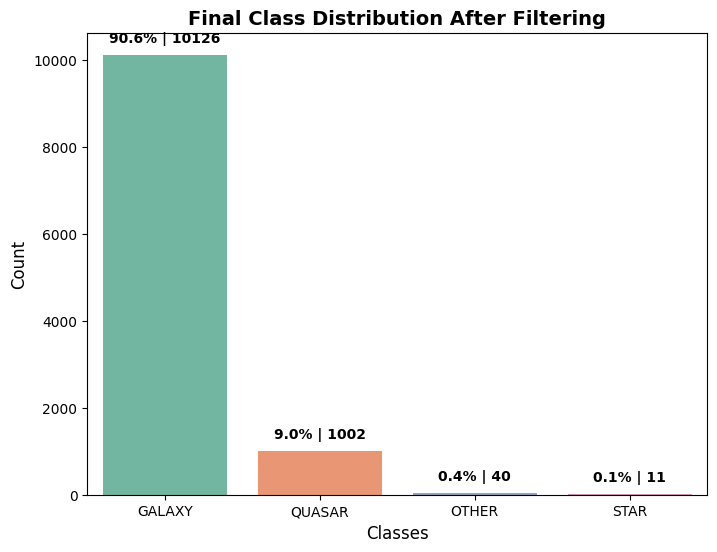

In [15]:
final_class_counts = pd.Series(Y_images_final).value_counts().sort_values(ascending=False)
total_final_count = final_class_counts.sum()

palette = sns.color_palette("Set2", n_colors=len(final_class_counts))

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x=final_class_counts.index,
    y=final_class_counts.values,
    palette=palette,
    dodge=False
)

for i, count in enumerate(final_class_counts):
    percent = (count / total_final_count) * 100
    ax.text(i, count + total_final_count * 0.02, f"{percent:.1f}% | {count}", 
            ha='center', va='bottom', fontsize=10, color="black", fontweight="bold")

ax.set_title("Final Class Distribution After Filtering", fontsize=14, fontweight="bold")
ax.set_xlabel("Classes", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend([], [], frameon=False)

plt.show()


In [16]:
label_encoder = LabelEncoder()
Y_images_final = label_encoder.fit_transform(Y_images_final)

# Images
### Process Image Data

In [17]:
n_samples_labels = Y_images_final.shape[0]
X_images = images[:n_samples_labels]  

nan_rows_images = np.isnan(X_images).any(axis=(1, 2, 3)) 

X_images_filtered = X_images[~nan_rows_images]
Y_images_filtered = Y_images_final[~nan_rows_images]

print(f"Filtered X_images shape: {X_images_filtered.shape}")
print(f"Filtered Y_images shape: {Y_images_filtered.shape}")

Filtered X_images shape: (11169, 5, 64, 64)
Filtered Y_images shape: (11169,)


In [18]:
redshifts = sfrs_z_filtered.loc[metadata_indices[idx_spectra], "Z"].values
redshifts = redshifts[~nan_rows]
filters = ["u", "g", "r", "i", "z"]

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_and_spectrum(images, spectra, labels, redshifts, label_encoder, class_name, obj_num):
    class_index = np.where(labels == label_encoder.transform([class_name])[0])[0]

    if len(class_index) > 0:
        idx = class_index[obj_num]
        img_channels = images[idx]
        spectrum = spectra[idx]

        redshift = redshifts[idx] if not np.isnan(redshifts[idx]) else "N/A"

        fig, axes = plt.subplots(1, 5, figsize=(15, 3), gridspec_kw={"wspace": 0.1})

        for i in range(5):
            axes[i].imshow(img_channels[i], cmap="viridis")  
            axes[i].set_title(f"{class_name} - {filters[i]}", fontsize=9)
            axes[i].axis("off")

        fig_spec, ax_spec = plt.subplots(figsize=(10, 3))
        wavelengths = np.linspace(3800, 9200, len(spectrum)) 
        ax_spec.plot(wavelengths, spectrum, color="blue")
        ax_spec.set_title(f"{class_name} - Spectrum (z={redshift:.3f})", fontsize=9)
        ax_spec.set_xlabel("Wavelength (Å)", fontsize=9)
        ax_spec.set_ylabel("Flux", fontsize=9)

        plt.show()
    else:
        print(f"No images found for class: {class_name}")


### QUASARS

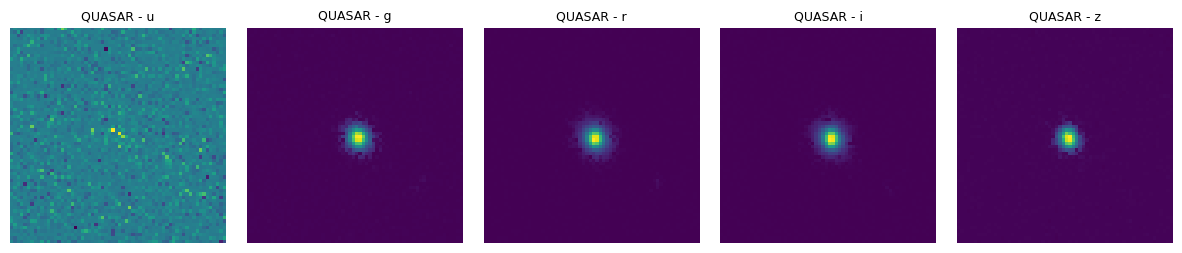

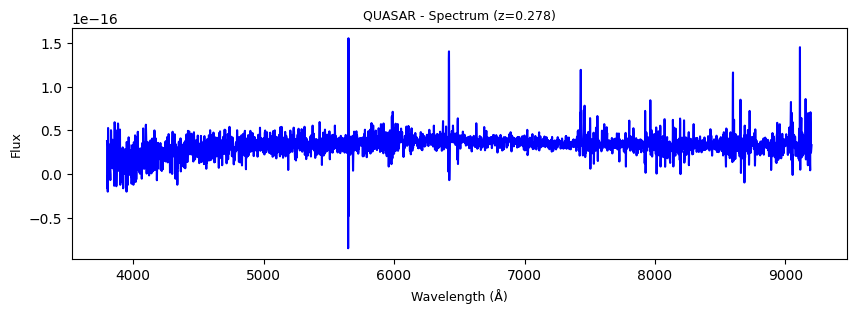

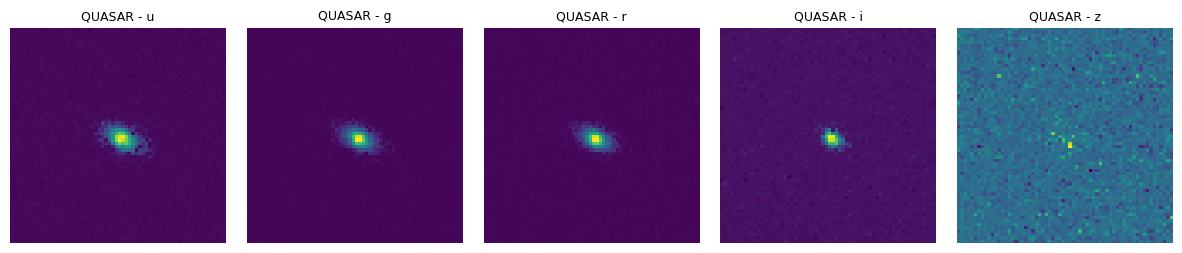

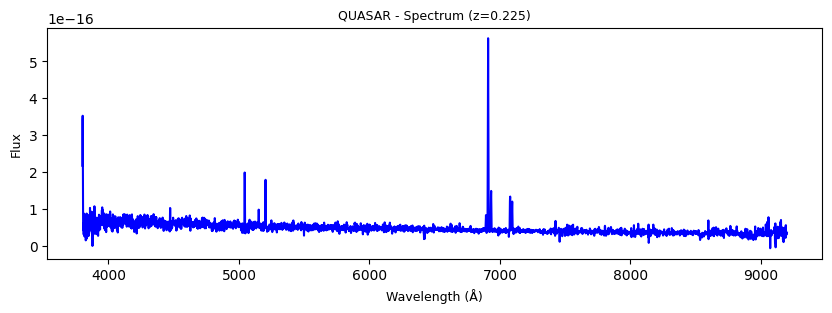

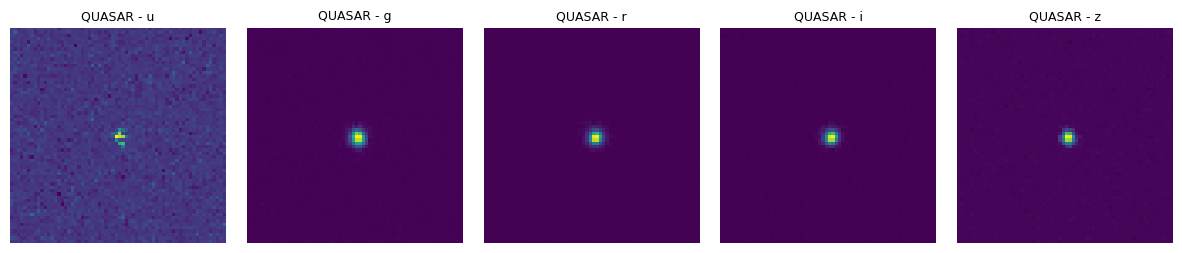

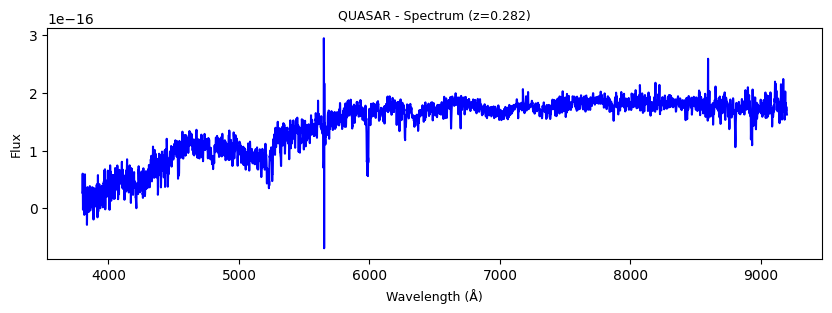

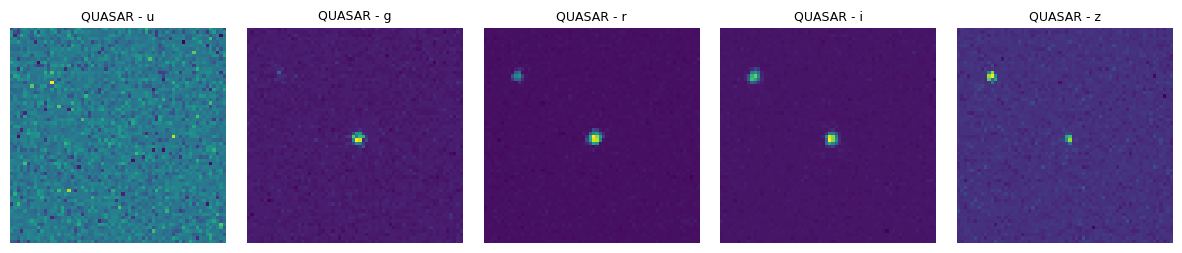

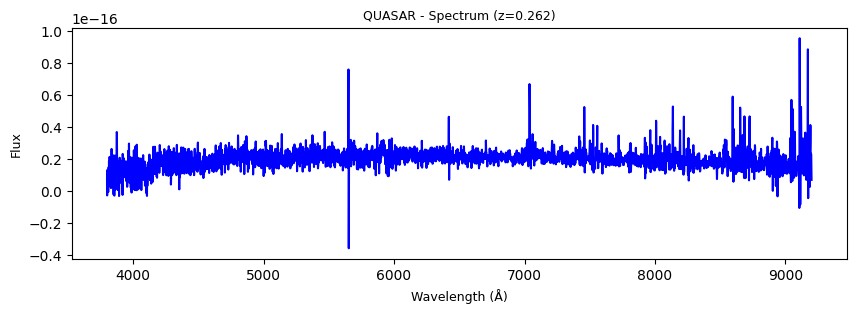

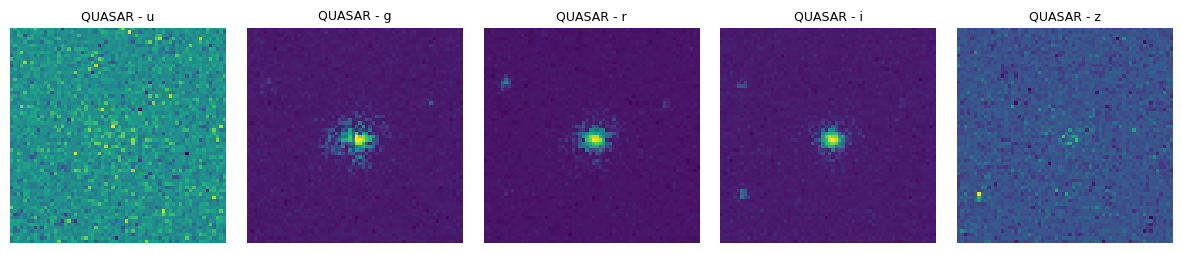

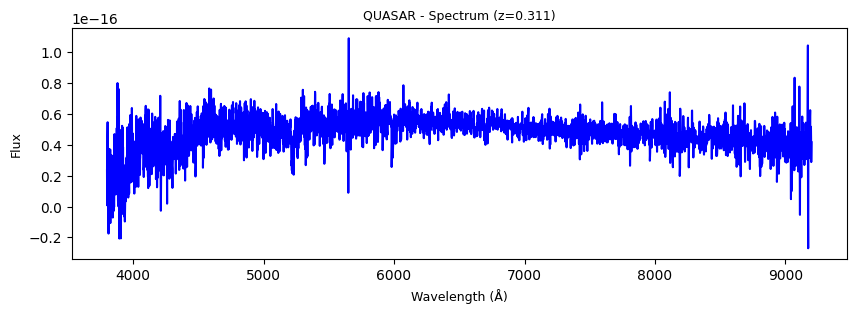

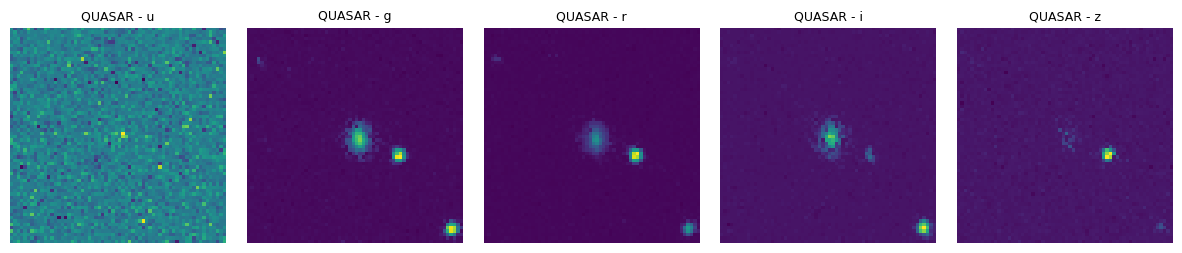

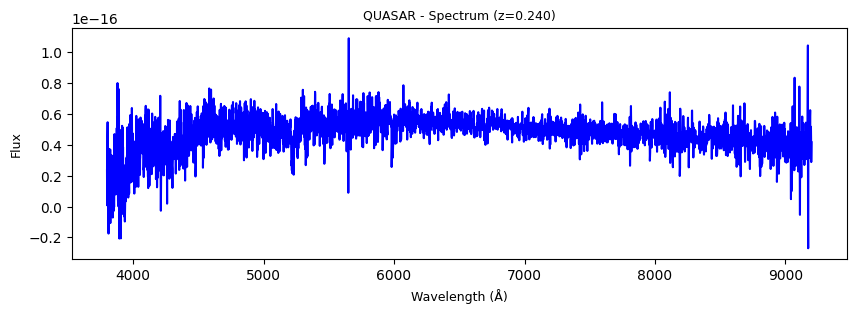

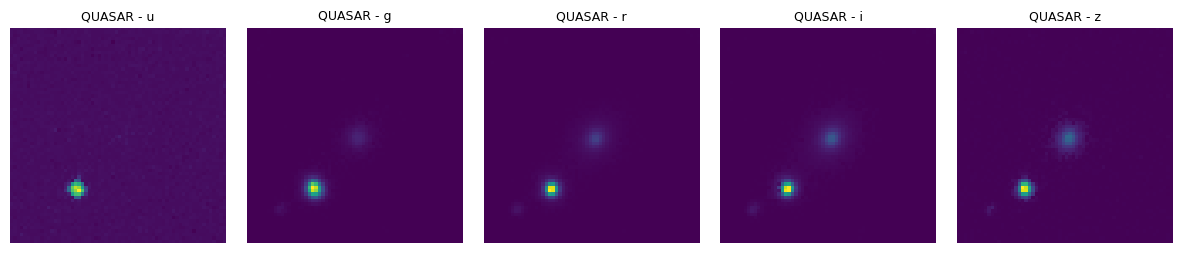

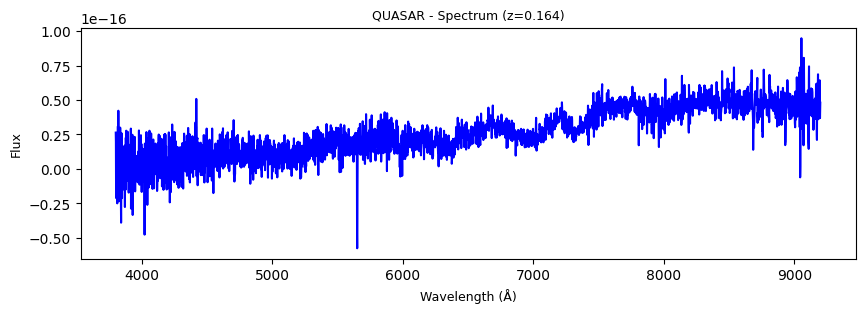

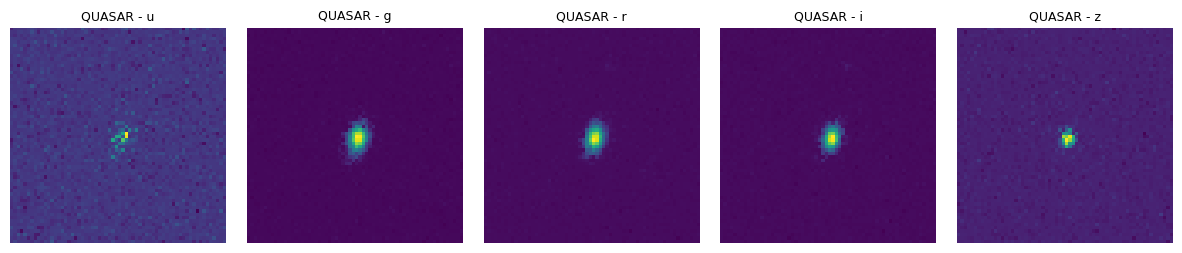

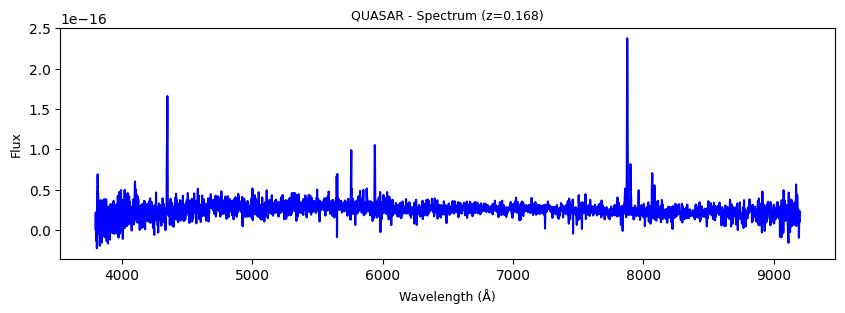

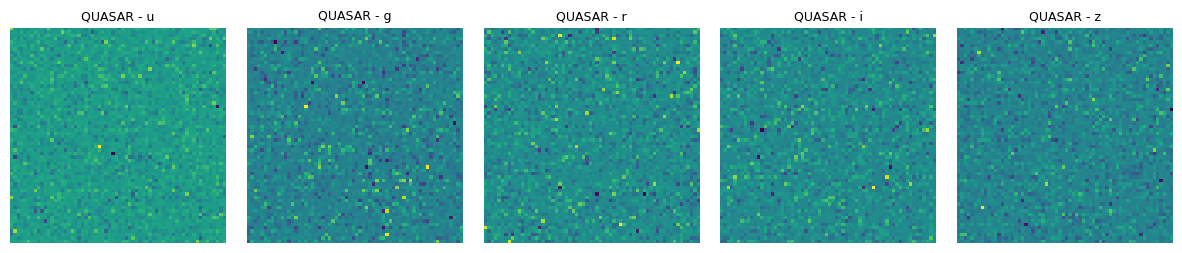

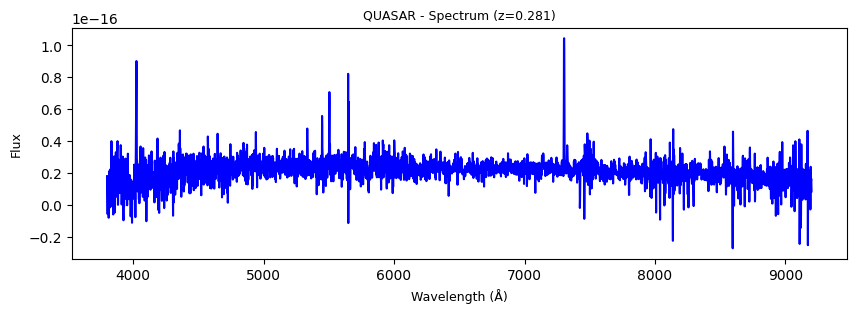

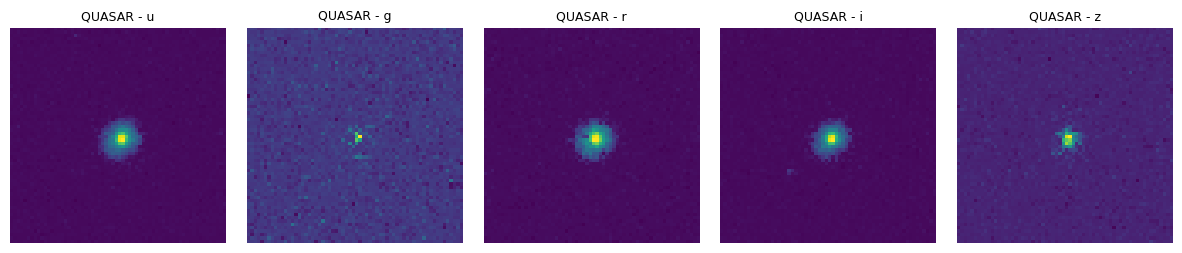

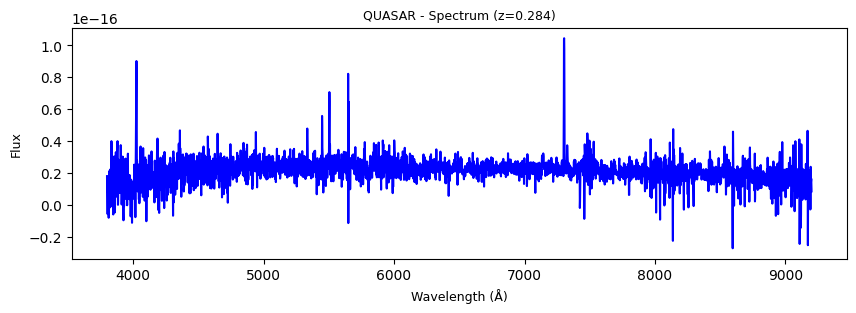

In [20]:
for i in range(10):
    plot_images_and_spectrum(X_images, X_spectra, Y_images_filtered, redshifts, label_encoder, "QUASAR", i)

### STARS

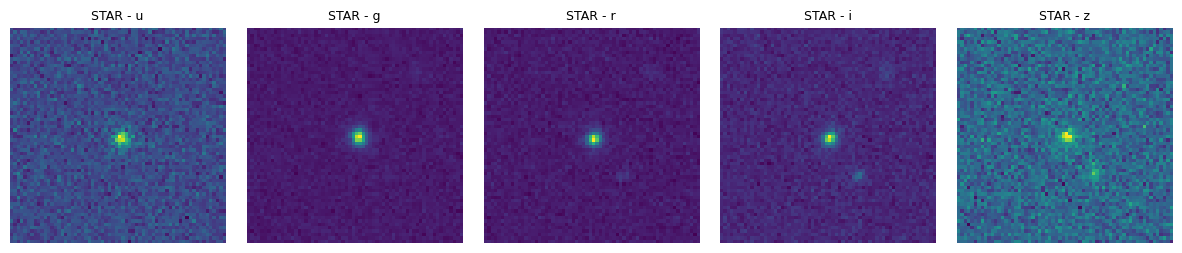

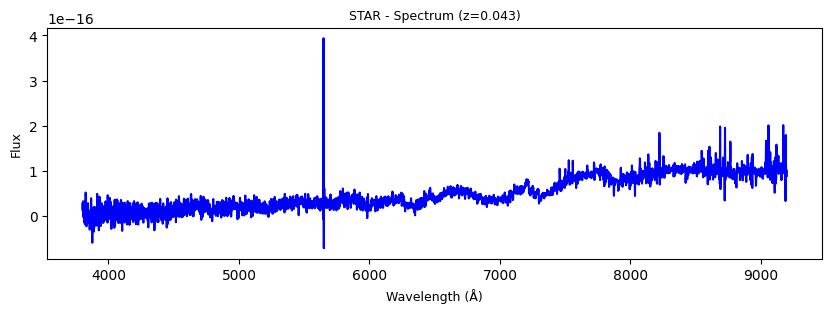

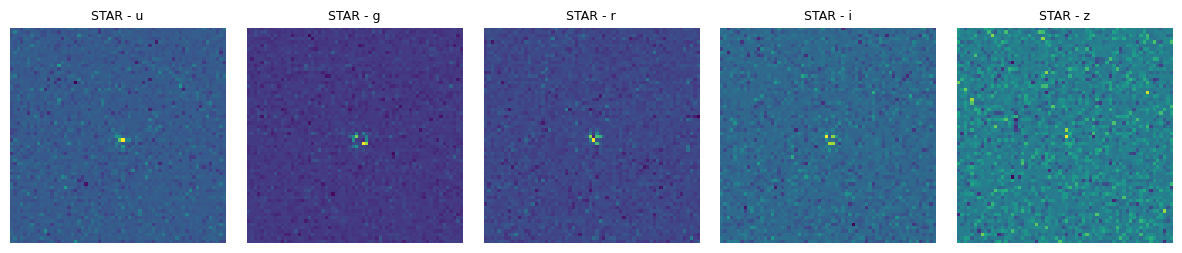

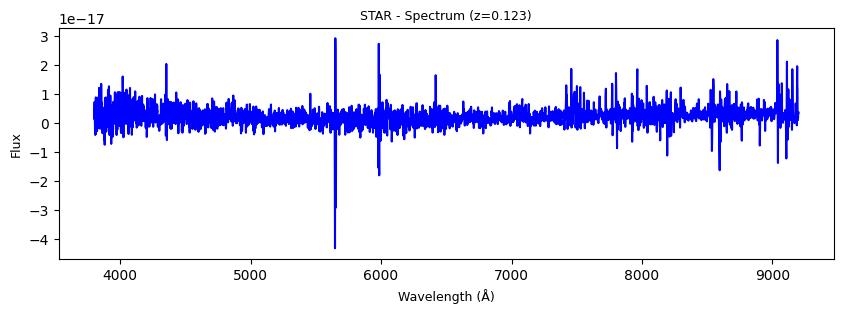

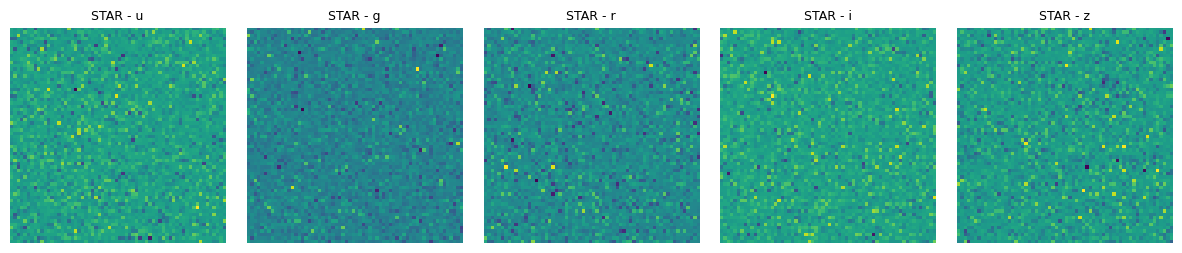

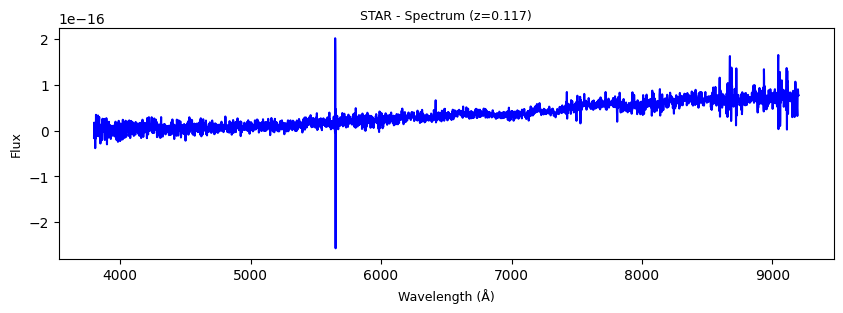

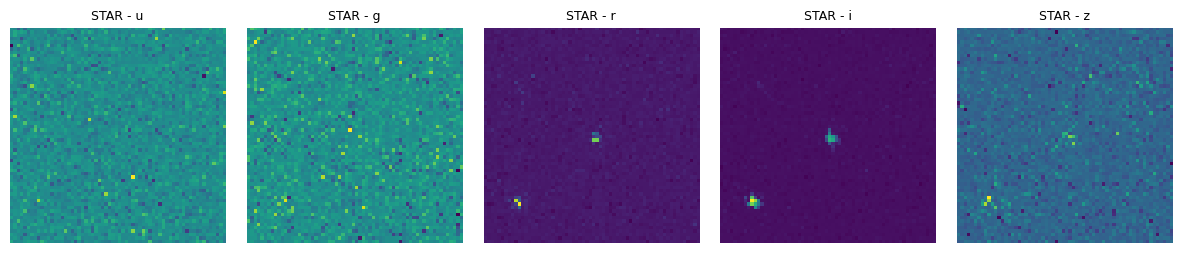

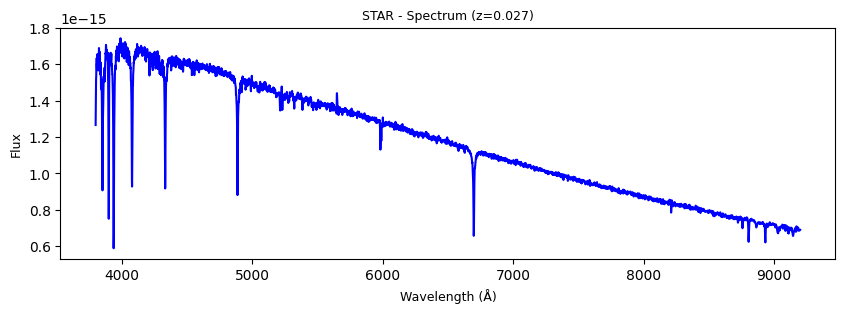

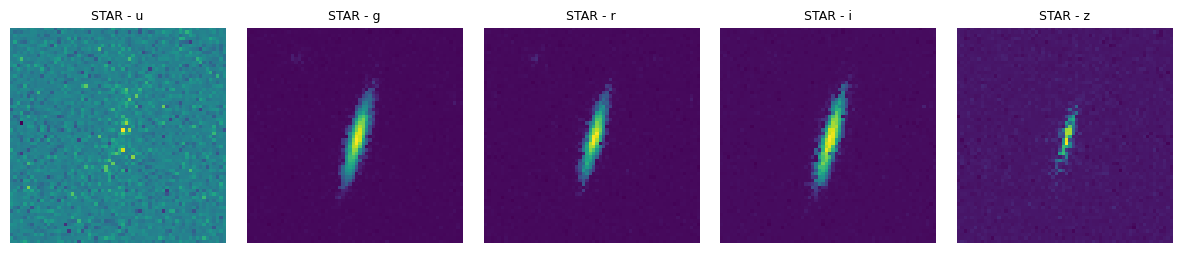

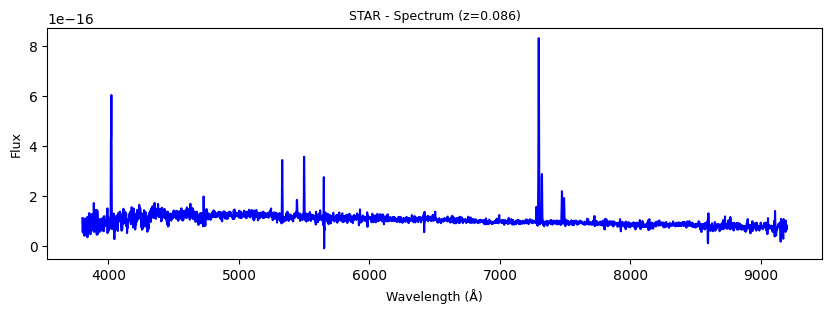

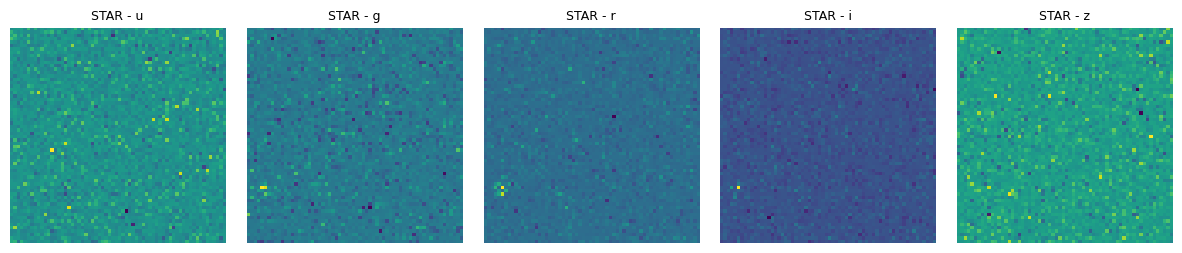

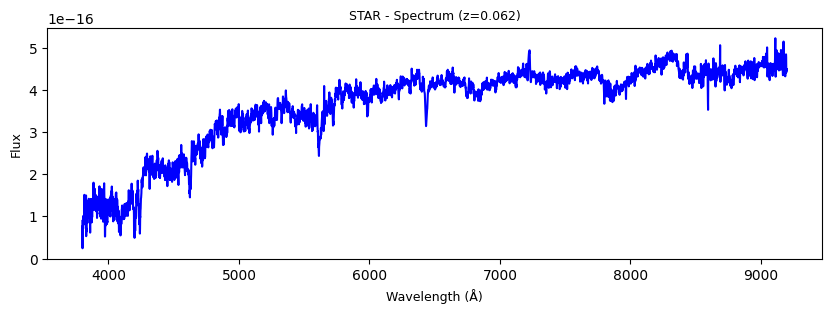

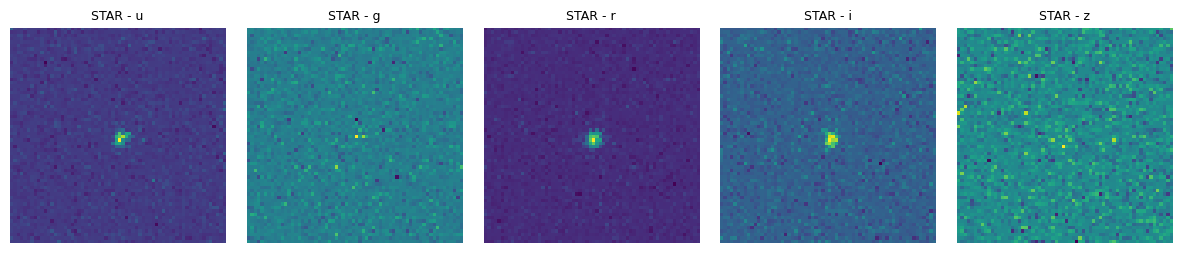

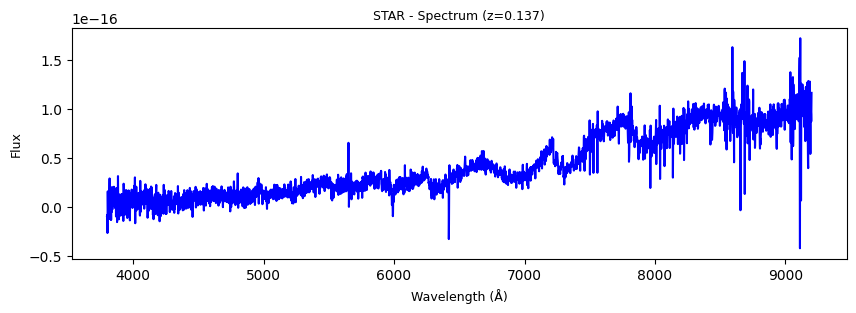

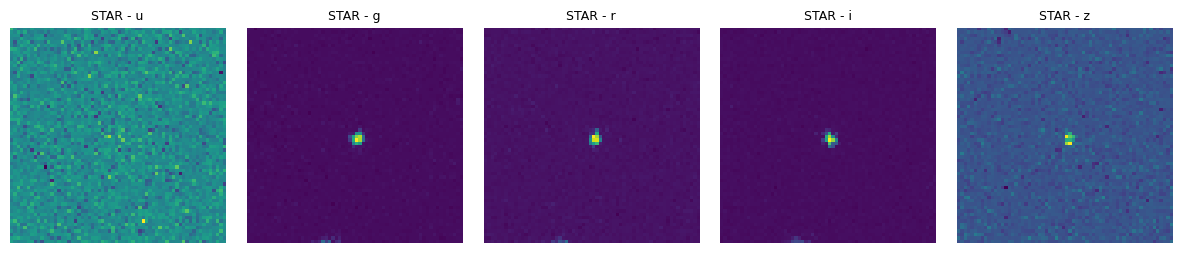

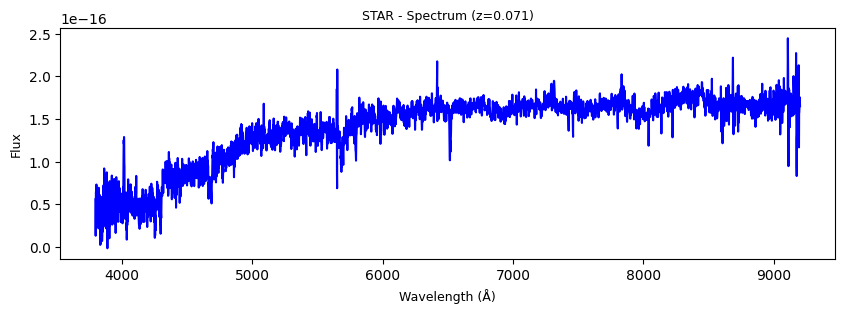

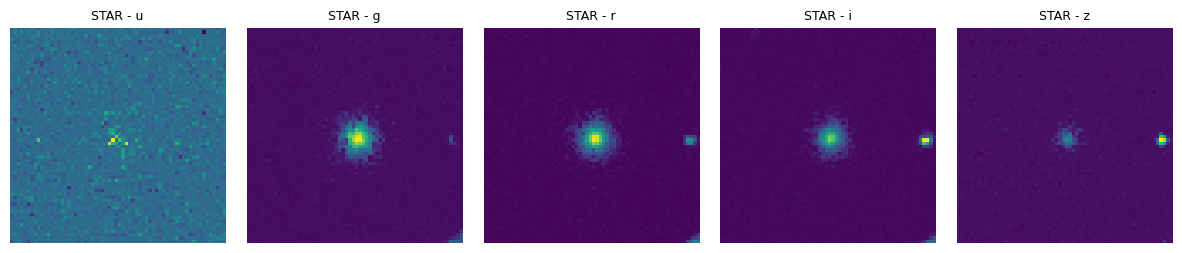

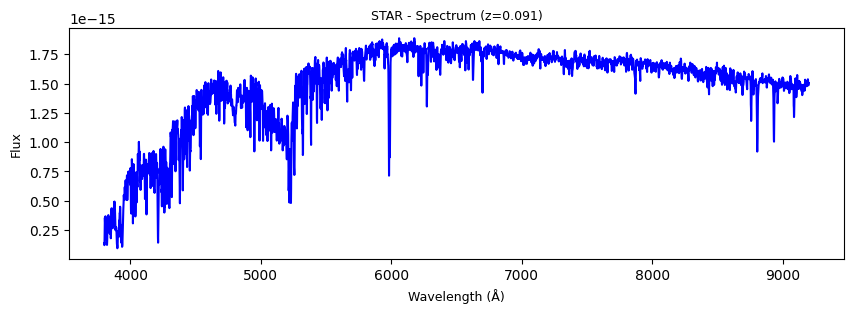

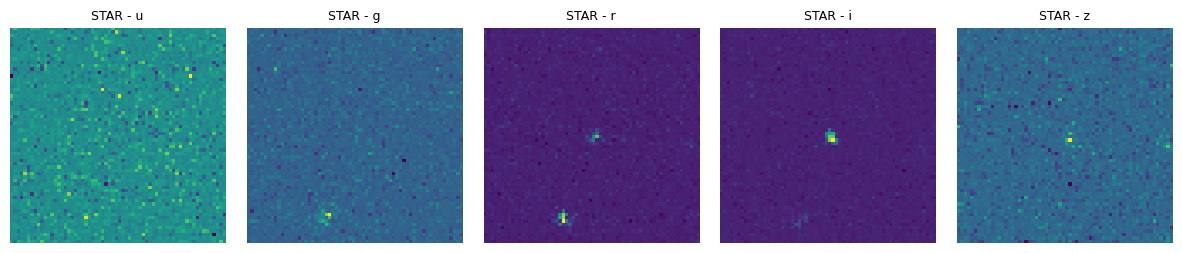

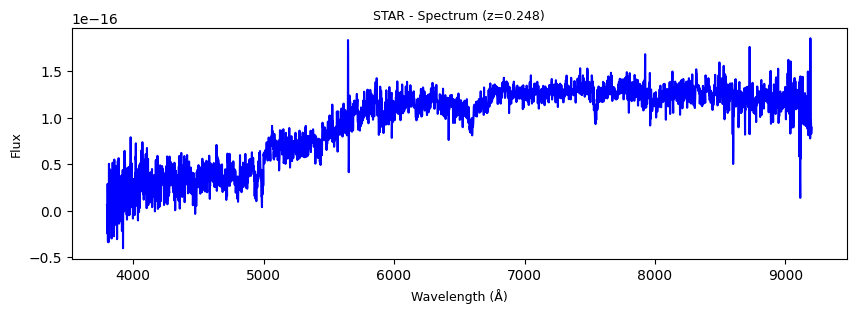

In [21]:
for i in range(10):
    plot_images_and_spectrum(X_images, X_spectra, Y_images_filtered, redshifts, label_encoder, "STAR", i)

### GALAXIES

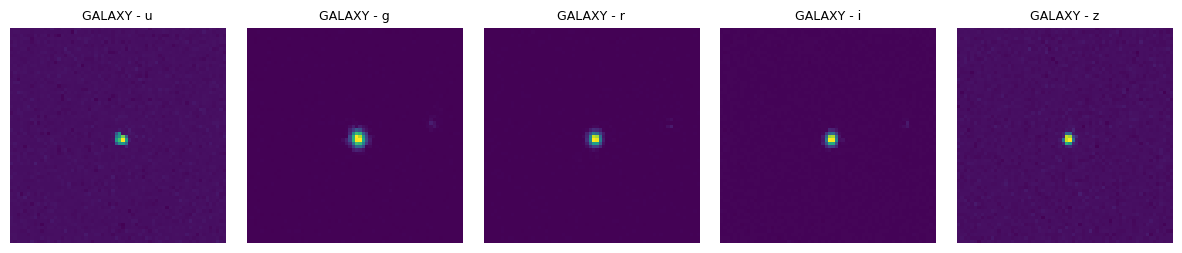

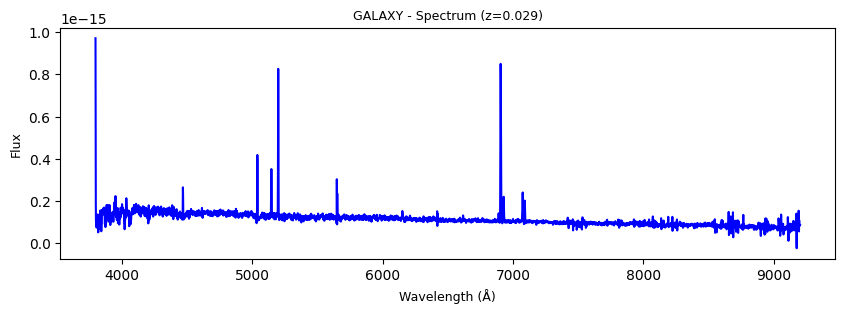

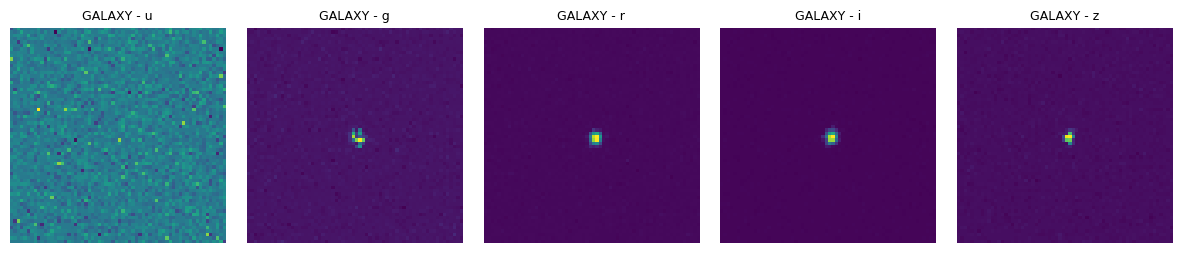

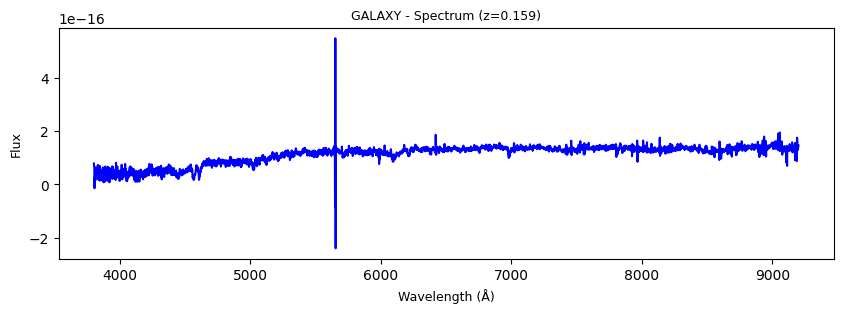

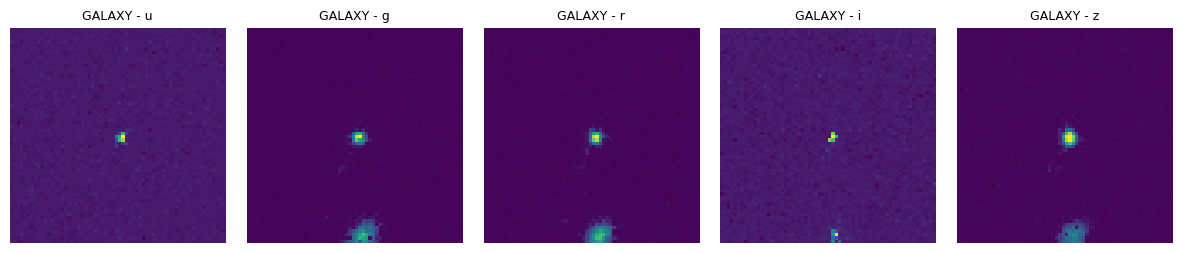

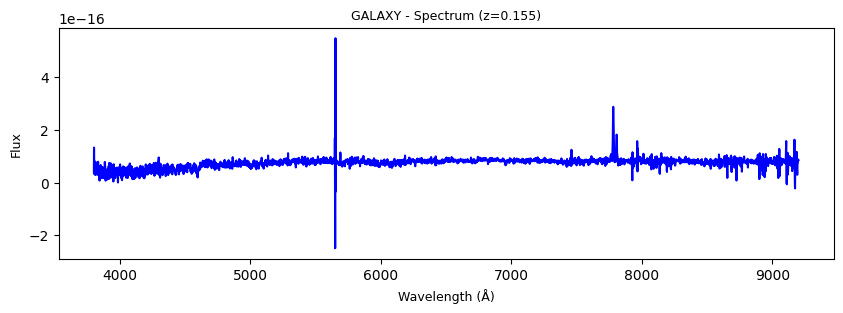

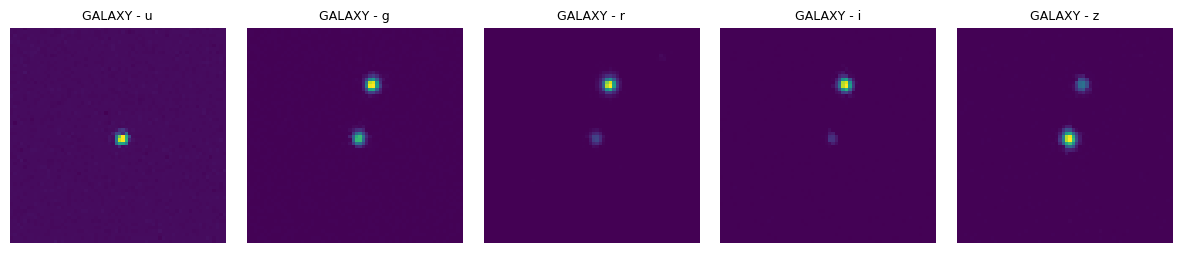

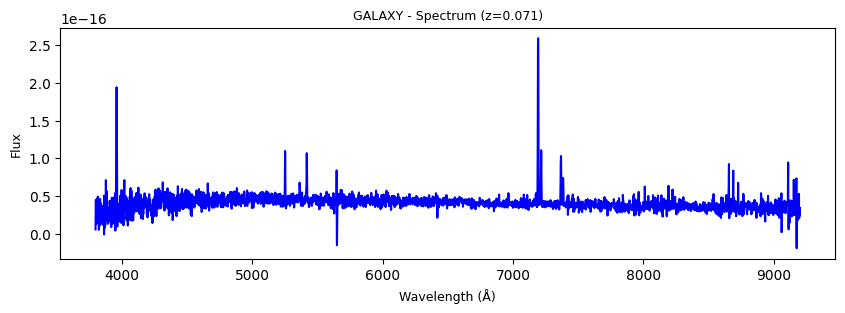

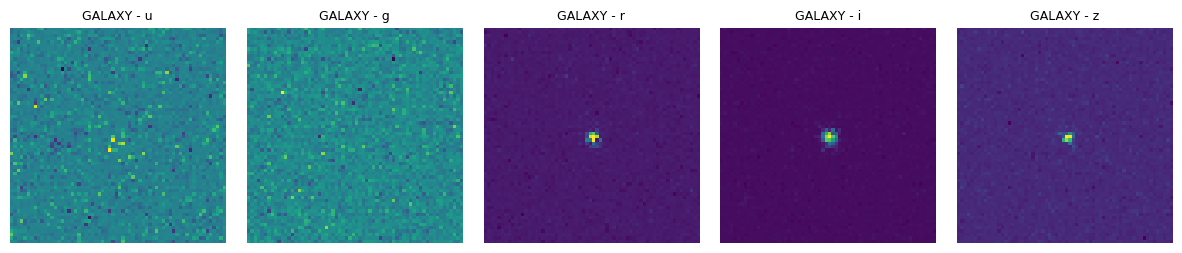

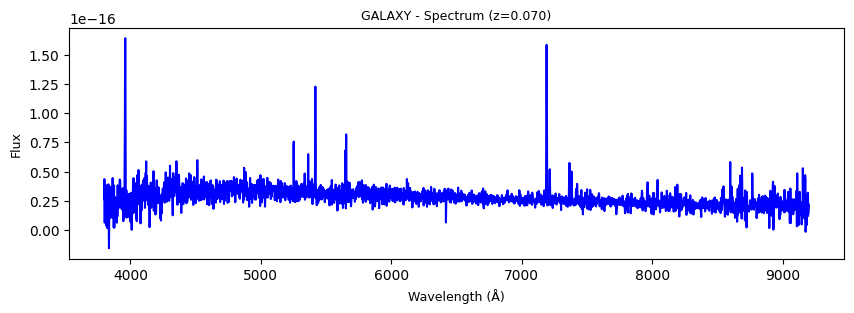

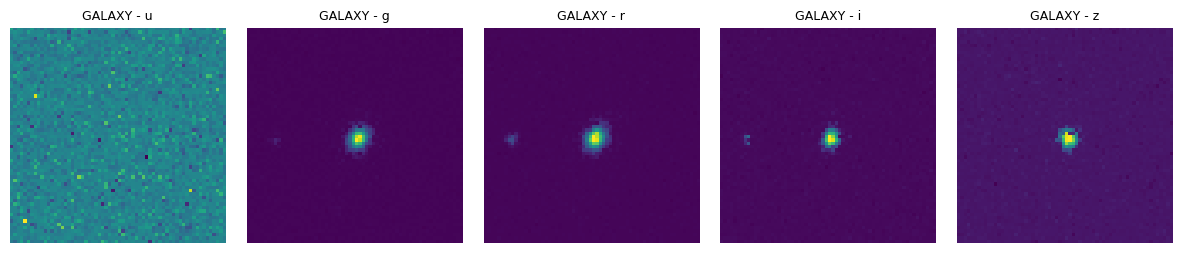

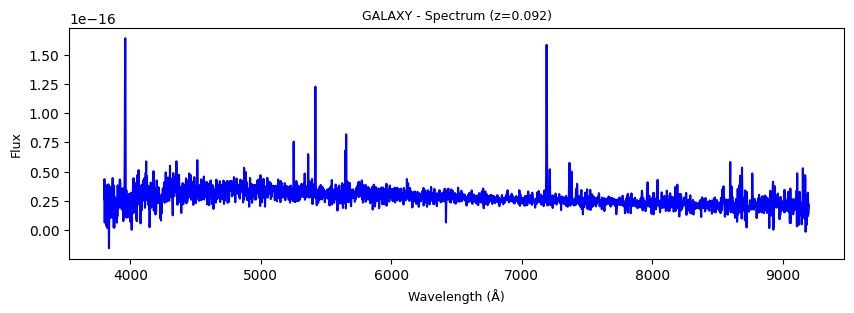

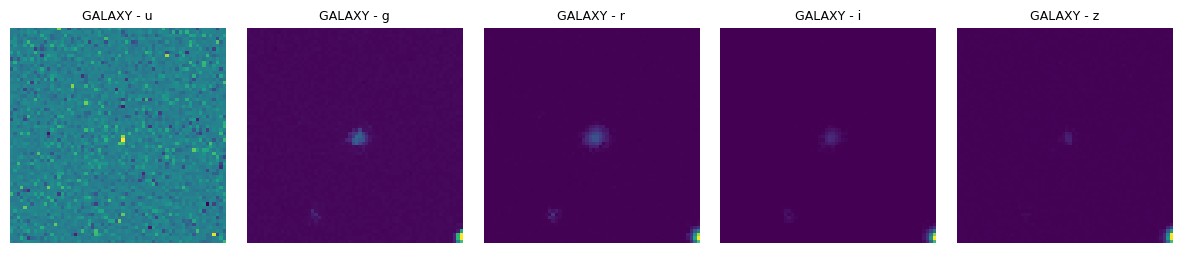

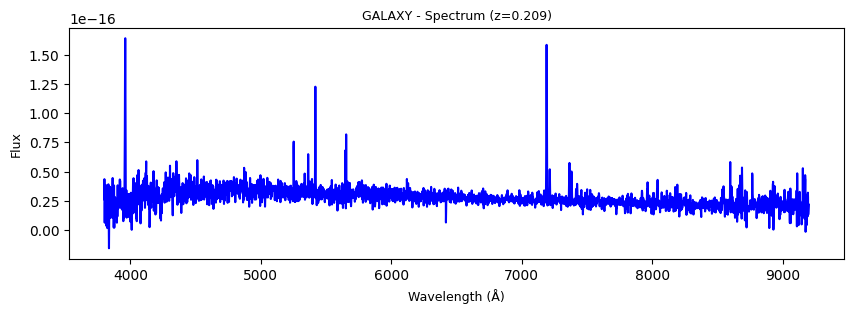

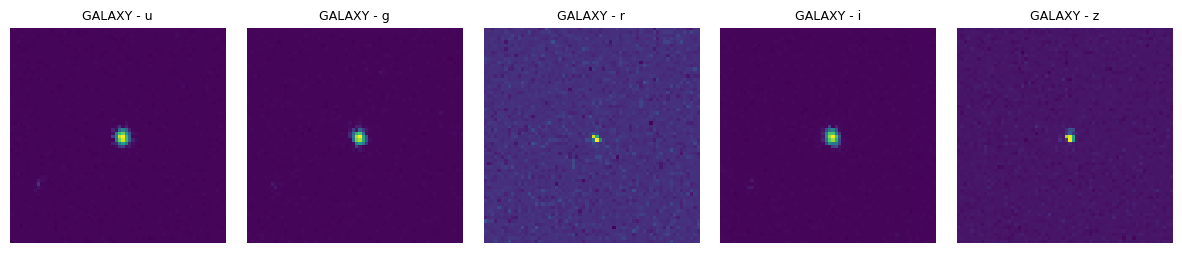

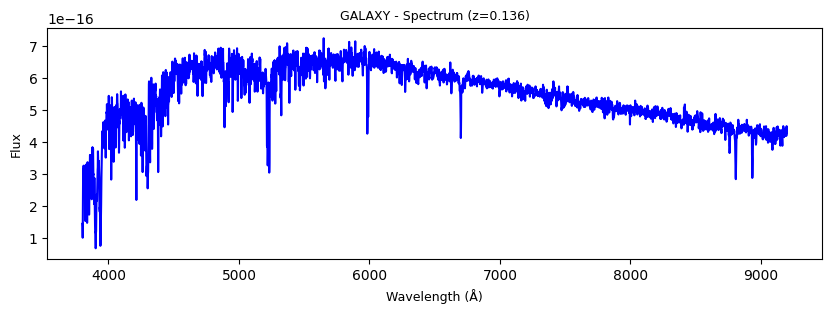

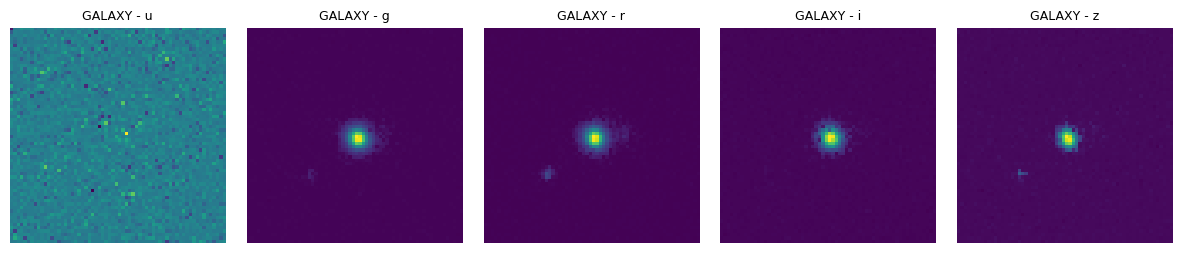

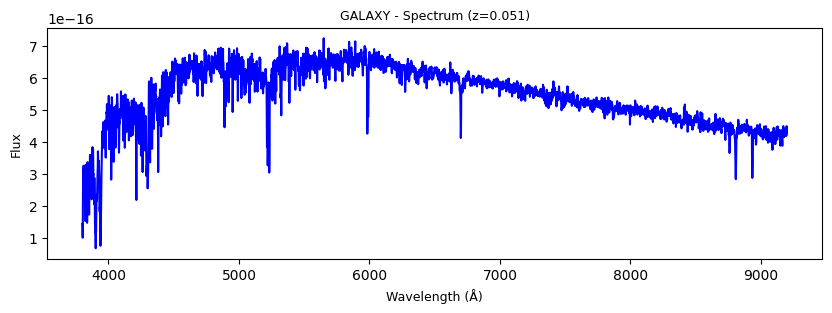

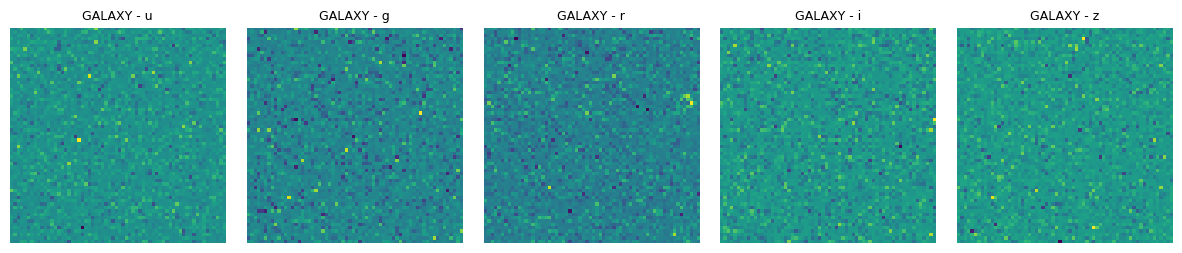

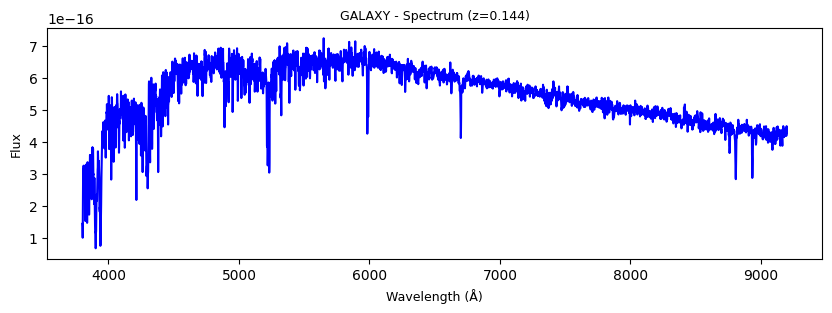

In [22]:
for i in range(10):
    plot_images_and_spectrum(X_images, X_spectra, Y_images_filtered, redshifts, label_encoder, "GALAXY", i)

### OTHER

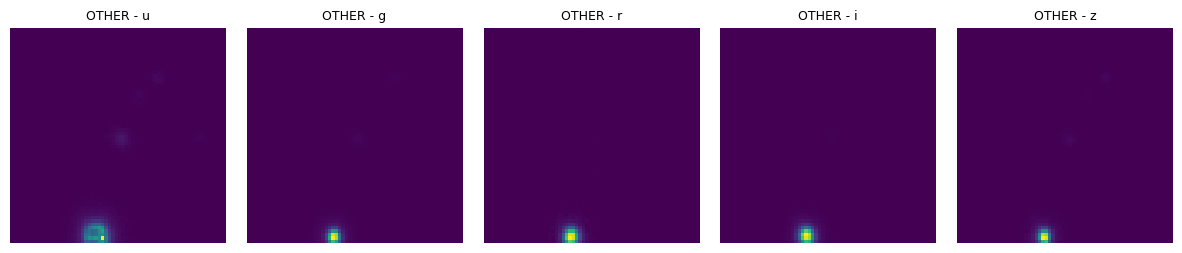

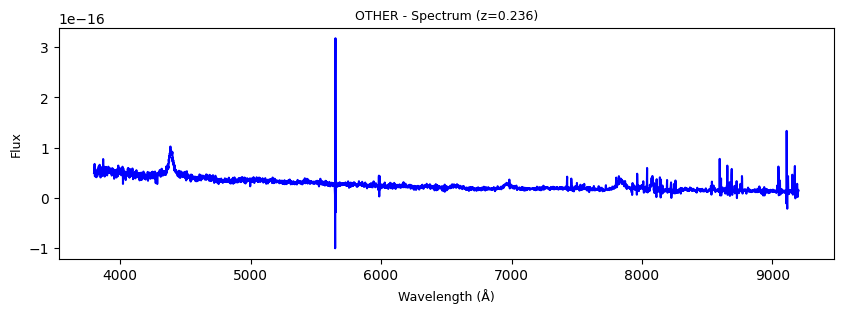

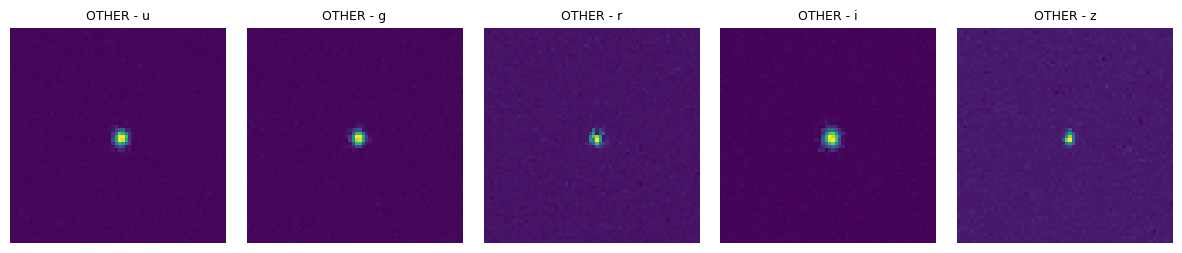

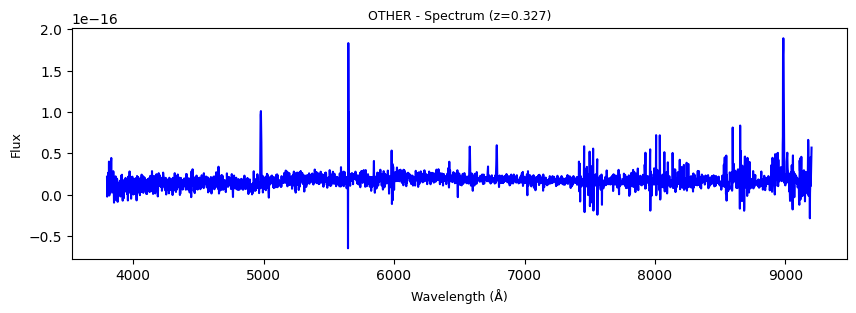

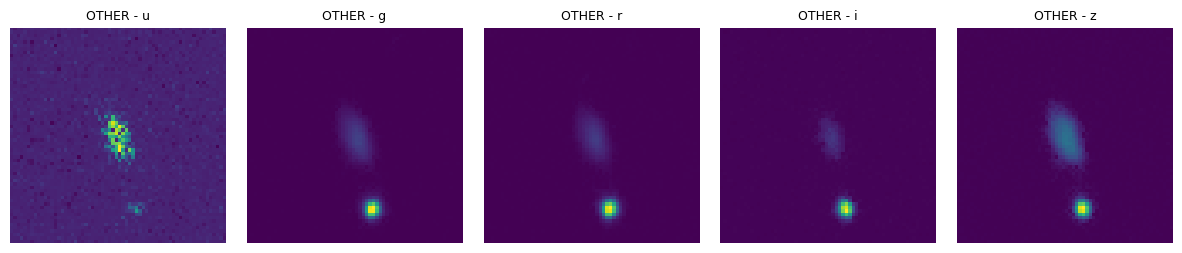

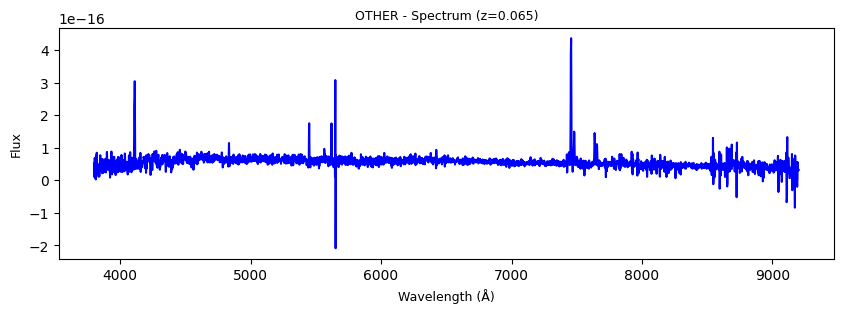

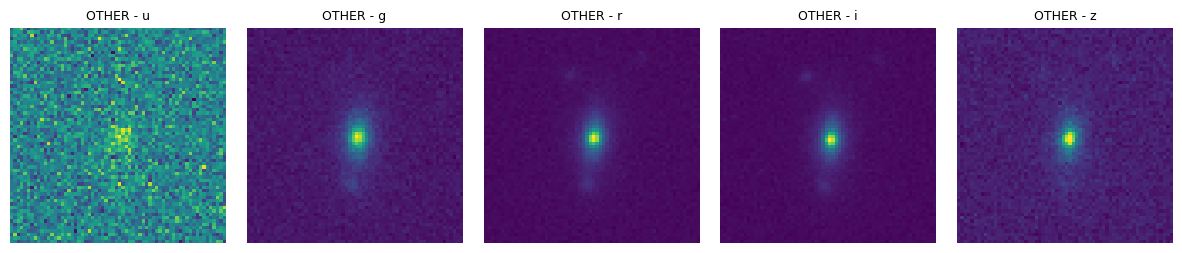

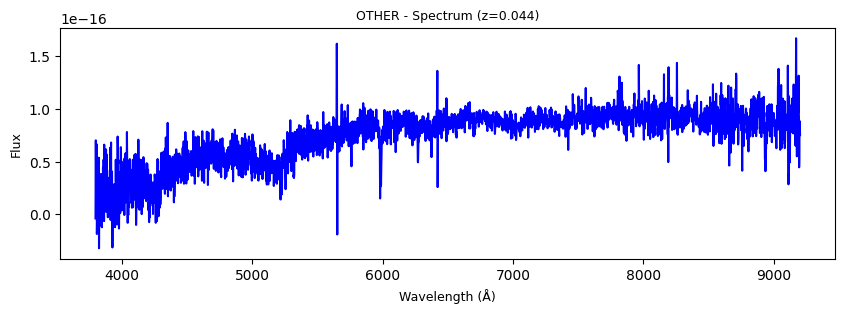

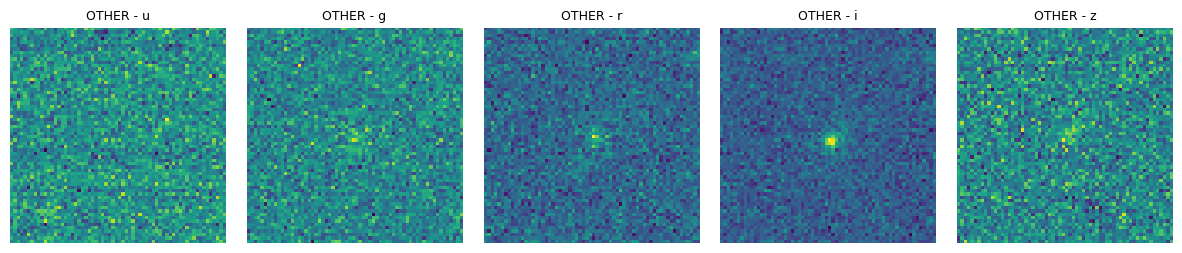

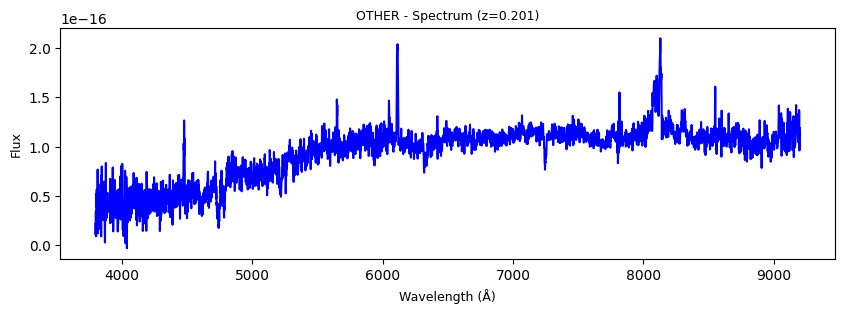

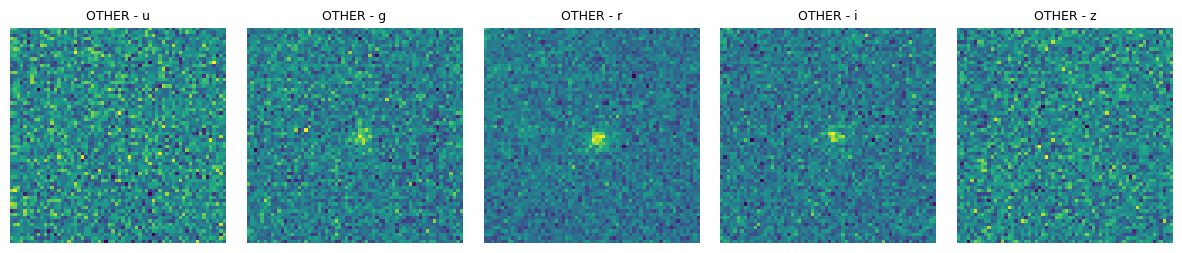

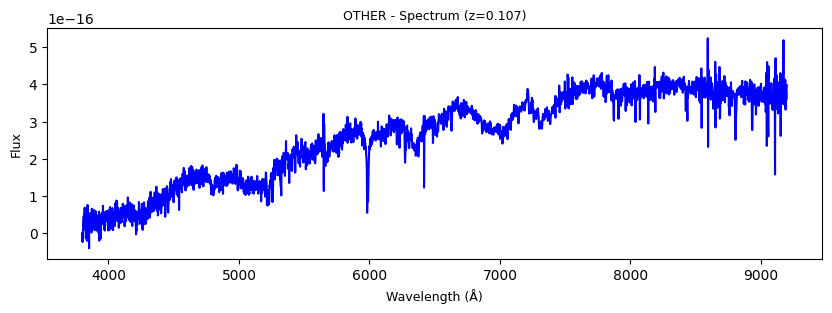

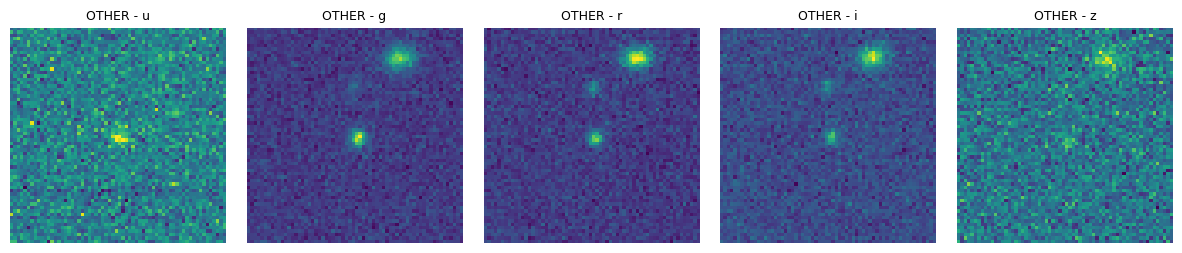

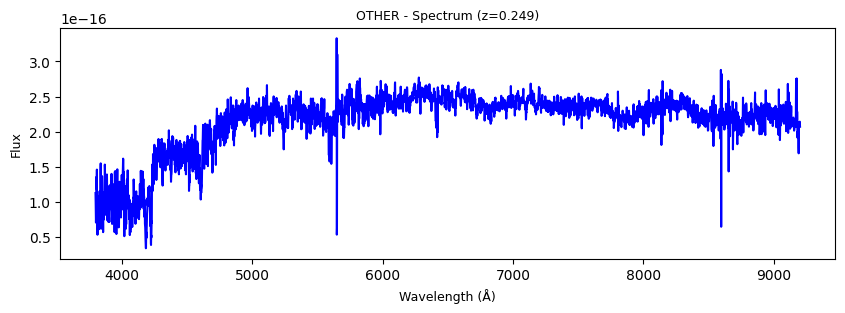

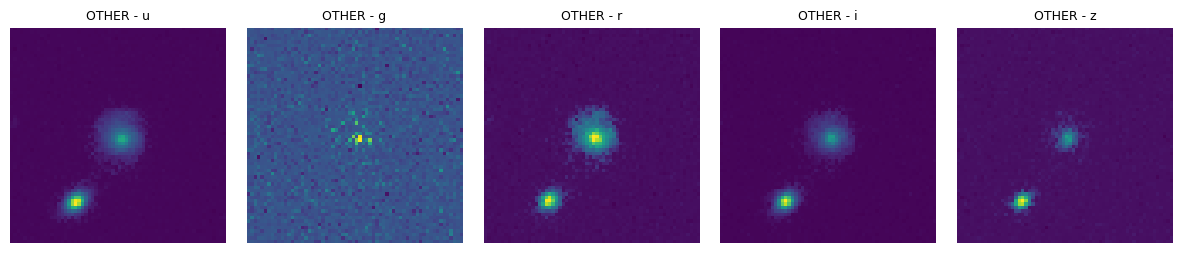

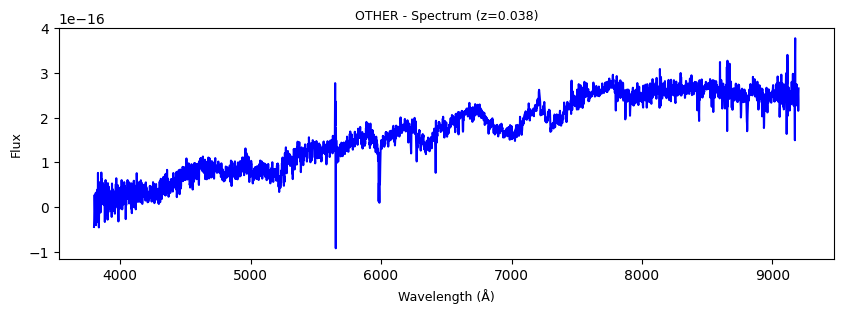

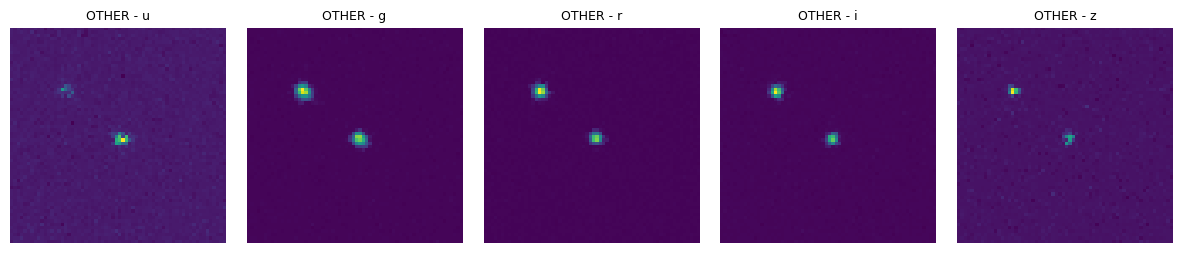

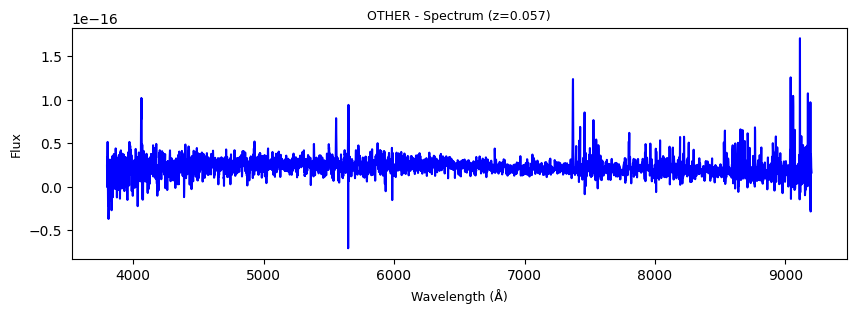

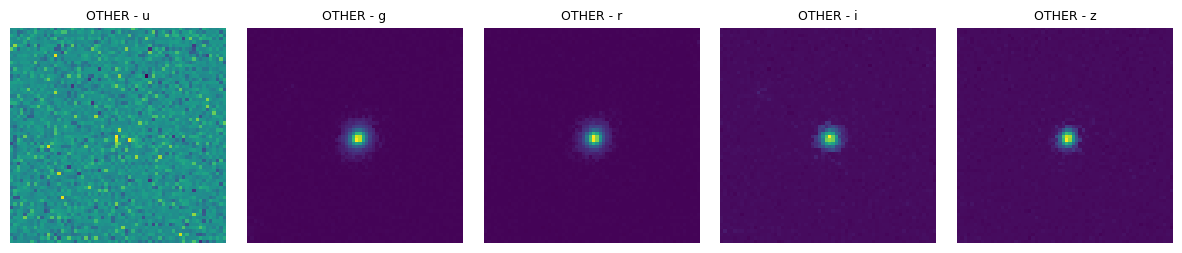

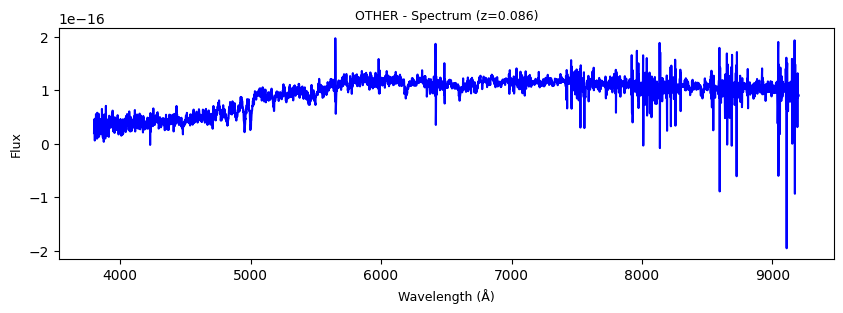

In [23]:
for i in range(10):
    plot_images_and_spectrum(X_images, X_spectra, Y_images_filtered, redshifts, label_encoder, "OTHER", i)